In [19]:
data_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks"

IO_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-IO"
# 0 to 19 trailel
VR_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-VR"
# 0 to 12 trailel
VV_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-VV"
# 0 to 12 trailel

Data_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-IO/S00_data.csv"
Labels_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-IO/S00_labels.csv"


In [2]:
import os
import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import butter, lfilter
import csv
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
def load_all_datasets(base_path):
    """
    تحميل البيانات من المجلدات الثلاثة
    """
    datasets = {}

    for dataset_name in ['EEG-IO', 'EEG-VR', 'EEG-VV']:
        dataset_path = os.path.join(base_path, dataset_name)
        if os.path.exists(dataset_path):
            datasets[dataset_name] = load_dataset(dataset_path, dataset_name)

    return datasets

def load_dataset(data_folder, dataset_type):
    """
    تحميل بيانات مجموعة محددة
    """
    all_data = []
    all_labels = []
    subject_ids = []

    # الحصول على قائمة الملفات
    data_files = [f for f in os.listdir(data_folder)
                 if os.path.isfile(os.path.join(data_folder, f)) and '_data' in f]

    for file_sig in data_files:
        file_stim = file_sig.replace('_data', '_labels')
        subject_id = file_sig.split('_')[0]

        print(f"Loading: {file_sig} from {dataset_type}")

        # تحميل البيانات الأساسية
        data_sig = load_raw_data(os.path.join(data_folder, file_sig), dataset_type)

        # تحميل التصنيفات
        interval_corrupt, groundtruth_blinks = decode_stim(data_folder, file_stim)

        # معالجة البيانات واستخراج العينات
        processed_data, labels = process_subject_data(data_sig, groundtruth_blinks, interval_corrupt)

        all_data.extend(processed_data)
        all_labels.extend(labels)
        subject_ids.extend([subject_id] * len(processed_data))

    return {
        'data': np.array(all_data),
        'labels': np.array(all_labels),
        'subject_ids': subject_ids,
        'dataset_type': dataset_type
    }

def load_raw_data(file_path, dataset_type):
    """
    تحميل البيانات الخام حسب نوع المجموعة
    """
    if dataset_type == 'EEG-IO':
        data_sig = np.loadtxt(open(file_path, "rb"), delimiter=";", skiprows=1, usecols=(0,1,2))
    elif dataset_type in ['EEG-VR', 'EEG-VV']:
        data_sig = np.loadtxt(open(file_path, "rb"), delimiter=",", skiprows=5, usecols=(0,1,2))
        data_sig = data_sig[0:(int(200*250)+1),:]  # 200 ثانية
        data_sig = data_sig[:,0:3]
        data_sig[:,0] = np.array(range(0,len(data_sig)))/250  # إعادة إنشاء الوقت

    return data_sig

In [4]:
def decode_stim(data_path, file_stim):
    """
    فك تشفير ملف التصنيفات
    """
    interval_corrupt = []
    blinks = []
    n_corrupt = 0
    reading_blinks = False

    with open(os.path.join(data_path, file_stim)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if row[0] == "corrupt":
                n_corrupt = int(row[1])
            elif n_corrupt > 0:
                if float(row[1]) == -1:
                    t_end = float('inf')  # حتى النهاية
                else:
                    t_end = float(row[1])
                interval_corrupt.append([float(row[0]), t_end])
                n_corrupt -= 1
            elif row[0] == "blinks":
                reading_blinks = True
            elif reading_blinks:
                blinks.append([float(row[0]), int(row[1])])

    return interval_corrupt, np.array(blinks)

def process_subject_data(data_sig, groundtruth_blinks, interval_corrupt, window_size=1.0, fs=250):
    """
    معالجة بيانات الشخص واستخراج العينات
    """
    # تطبيق المرشح
    data_sig[:,1] = lowpass(data_sig[:,1], 10, fs, 4)
    data_sig[:,2] = lowpass(data_sig[:,2], 10, fs, 4)

    samples = []
    labels = []

    window_samples = int(window_size * fs)

    # إنشاء عينات إيجابية (تحتوي على رمشات)
    for blink_time, blink_type in groundtruth_blinks:
        if blink_type < 2:  # الرمشات العادية والمستحثة فقط
            # إيجاد أقرب عينة زمنية
            sample_idx = np.argmin(np.abs(data_sig[:,0] - blink_time))

            # استخراج النافذة حول الرمشة
            start_idx = max(0, sample_idx - window_samples//2)
            end_idx = min(len(data_sig), sample_idx + window_samples//2)

            if end_idx - start_idx == window_samples:
                window_data = data_sig[start_idx:end_idx, 1:3]  # القناتين Fp1 و Fp2
                samples.append(window_data)
                labels.append(1)  # رمشة

    # إنشاء عينات سلبية (لا تحتوي على رمشات)
    n_negative = len(samples)  # نفس عدد العينات الإيجابية
    negative_count = 0

    for i in range(0, len(data_sig) - window_samples, window_samples//2):
        if negative_count >= n_negative:
            break

        # التحقق إذا كانت النافذة في منطقة فاسدة
        in_corrupt = False
        window_start_time = data_sig[i, 0]
        window_end_time = data_sig[i + window_samples, 0]

        for corrupt_start, corrupt_end in interval_corrupt:
            if not (window_end_time <= corrupt_start or window_start_time >= corrupt_end):
                in_corrupt = True
                break

        if in_corrupt:
            continue

        # التحقق إذا كانت النافذة تحتوي على رمشة
        has_blink = False
        for blink_time, _ in groundtruth_blinks:
            if window_start_time <= blink_time <= window_end_time:
                has_blink = True
                break

        if not has_blink:
            window_data = data_sig[i:i + window_samples, 1:3]
            samples.append(window_data)
            labels.append(0)  # لا رمشة
            negative_count += 1

    return samples, labels

def lowpass(sig, fc, fs, butter_filt_order):
    """
    مرشح تمرير منخفض
    """
    B, A = butter(butter_filt_order, np.array(fc)/(fs/2), btype='low')
    return lfilter(B, A, sig, axis=0)

def extract_features(samples):
    """
    استخراج الميزات من العينات
    """
    features = []

    for sample in samples:
        sample_features = []

        for channel in range(sample.shape[1]):  # لكل قناة
            channel_data = sample[:, channel]

            # الميزات الزمنية
            mean_val = np.mean(channel_data)
            std_val = np.std(channel_data)
            variance = np.var(channel_data)
            rms = np.sqrt(np.mean(channel_data**2))

            # ميزات الذروة
            peaks, properties = signal.find_peaks(
                np.abs(channel_data),
                height=np.std(channel_data),
                distance=10  # مسافة دنيا بين الذروات
            )
            n_peaks = len(peaks)

            # ميزات التكامل والانحراف
            integral = np.trapz(np.abs(channel_data))
            skewness = signal.windows.tukey(len(channel_data)).std()

            sample_features.extend([mean_val, std_val, variance, rms,
                                  n_peaks, integral, skewness])

        # ميزات بين القنوات
        correlation = np.corrcoef(sample[:,0], sample[:,1])[0,1]
        sample_features.append(correlation)

        features.append(sample_features)

    return np.array(features)

In [5]:
def train_models(X, y):
    """
    تدريب نماذج متعددة
    """
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='rbf', random_state=42, probability=True)
    }

    results = {}

    for name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])

        # التحقق المتقاطع
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

        # تدريب النموذج النهائي
        pipeline.fit(X, y)

        results[name] = {
            'mean_accuracy': np.mean(scores),
            'std_accuracy': np.std(scores),
            'model': pipeline,
            'cv_scores': scores
        }

        print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

    return results

In [9]:
# السيناريو الرئيسي للتدريب
def main():
    base_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks"  # المسار الأساسي للمجلدات

    # تحميل جميع البيانات
    print("جاري تحميل البيانات من المجلدات الثلاثة...")
    datasets = load_all_datasets(base_path)

    # دمج البيانات من جميع المجلدات
    all_features = []
    all_labels = []
    dataset_types = []

    for dataset_name, dataset in datasets.items():
        features = extract_features(dataset['data'])
        all_features.append(features)
        all_labels.append(dataset['labels'])
        dataset_types.extend([dataset_name] * len(features))

    X = np.vstack(all_features)
    y = np.hstack(all_labels)

    print(f"البيانات الكلية: {X.shape[0]} عينة، {X.shape[1]} ميزة")
    print(f"التوزيع: {np.sum(y==1)} رمشة، {np.sum(y==0)} غير رمشة , الدرجه ال2 {np.sum(y==2)}")

    # تدريب النماذج
    print("\nجاري تدريب النماذج على البيانات المجمعة...")
    results = train_models(X, y)

    return results, X, y, dataset_types

# تشغيل السيناريو الرئيسي
if __name__ == "__main__":
    results, X, y, dataset_types = main()

جاري تحميل البيانات من المجلدات الثلاثة...
Loading: S00_data.csv from EEG-IO
Loading: S01_data.csv from EEG-IO
Loading: S02_data.csv from EEG-IO
Loading: S03_data.csv from EEG-IO
Loading: S04_data.csv from EEG-IO
Loading: S05_data.csv from EEG-IO
Loading: S06_data.csv from EEG-IO
Loading: S07_data.csv from EEG-IO
Loading: S08_data.csv from EEG-IO
Loading: S09_data.csv from EEG-IO
Loading: S10_data.csv from EEG-IO
Loading: S11_data.csv from EEG-IO
Loading: S12_data.csv from EEG-IO
Loading: S13_data.csv from EEG-IO
Loading: S14_data.csv from EEG-IO
Loading: S15_data.csv from EEG-IO
Loading: S16_data.csv from EEG-IO
Loading: S17_data.csv from EEG-IO
Loading: S18_data.csv from EEG-IO
Loading: S19_data.csv from EEG-IO
Loading: S00R_data.csv from EEG-VR
Loading: S01R_data.csv from EEG-VR
Loading: S02R_data.csv from EEG-VR
Loading: S03R_data.csv from EEG-VR
Loading: S04R_data.csv from EEG-VR
Loading: S05R_data.csv from EEG-VR
Loading: S06R_data.csv from EEG-VR
Loading: S07R_data.csv from EEG-

/tmp/ipython-input-1628475849.py:127: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(np.abs(channel_data))


البيانات الكلية: 3720 عينة، 15 ميزة
التوزيع: 1860 رمشة، 1860 غير رمشة , الدرجه ال2 0

جاري تدريب النماذج على البيانات المجمعة...
Random Forest: 0.947 ± 0.012
SVM: 0.907 ± 0.015


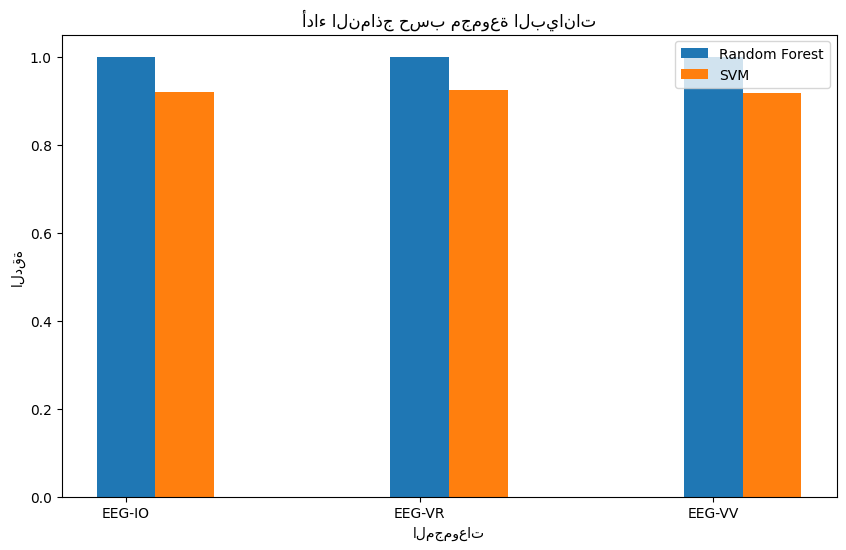

In [10]:
def advanced_analysis(results, X, y, dataset_types):
    """
    تحليلات متقدمة
    """
    # 1. تحليل الأداء حسب نوع المجموعة
    unique_datasets = np.unique(dataset_types)
    dataset_performance = {}

    for dataset in unique_datasets:
        mask = np.array(dataset_types) == dataset
        X_dataset = X[mask]
        y_dataset = y[mask]

        dataset_accuracy = {}
        for name, result in results.items():
            model = result['model']
            accuracy = model.score(X_dataset, y_dataset)
            dataset_accuracy[name] = accuracy

        dataset_performance[dataset] = dataset_accuracy

    # 2. رسم أداء المجموعات
    plt.figure(figsize=(10, 6))
    for model_name in results.keys():
        accuracies = [dataset_performance[dataset][model_name] for dataset in unique_datasets]
        plt.bar(np.arange(len(unique_datasets)) + 0.2 * list(results.keys()).index(model_name),
                accuracies, width=0.2, label=model_name)

    plt.xlabel('المجموعات')
    plt.ylabel('الدقة')
    plt.title('أداء النماذج حسب مجموعة البيانات')
    plt.xticks(np.arange(len(unique_datasets)), unique_datasets)
    plt.legend()
    plt.show()

    return dataset_performance

# تشغيل التحليل المتقدم
dataset_performance = advanced_analysis(results, X, y, dataset_types)

In [11]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import butter, lfilter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import joblib

class WheelchairBlinkController:
    """
    نظام تحكم في الكرسي المتحرك باستخدام الرمش المزدوج
    """

    def __init__(self, model_path=None):
        self.fs = 250  # تردد العينة
        self.window_size = 2.0  # حجم النافذة بالثواني
        self.window_samples = int(self.window_size * self.fs)
        self.is_moving = True  # حالة الكرسي الافتراضية (متحرك)
        self.data_buffer = np.array([])

        # تحميل النموذج إذا كان موجوداً
        if model_path and os.path.exists(model_path):
            self.model = joblib.load(model_path)
            self.scaler = joblib.load(model_path.replace('.pkl', '_scaler.pkl'))
        else:
            self.model = None
            self.scaler = StandardScaler()

    def lowpass(self, sig, fc, fs, order=4):
        """مرشح تمرير منخفض"""
        B, A = butter(order, np.array(fc)/(fs/2), btype='low')
        return lfilter(B, A, sig, axis=0)

    def detect_double_blink_pattern(self, blink_times, max_interval=0.8):
        """
        اكتشاف نمط الرمش المزدوج من قائمة الأوقات
        """
        if len(blink_times) < 2:
            return []

        double_blinks = []
        sorted_times = sorted(blink_times)

        i = 0
        while i < len(sorted_times) - 1:
            time_diff = sorted_times[i+1] - sorted_times[i]
            if time_diff <= max_interval:
                double_blinks.append((sorted_times[i], sorted_times[i+1]))
                i += 2  # تخطي الرمشتين
            else:
                i += 1

        return double_blinks

    def extract_simple_features(self, sample):
        """
        استخراج ميزات مبسطة وفعالة للرمش المزدوج
        """
        features = []

        for channel in range(sample.shape[1]):
            channel_data = sample[:, channel]

            # ميزات أساسية
            std_val = np.std(channel_data)
            variance = np.var(channel_data)

            # اكتشاف الذروات
            peaks, properties = signal.find_peaks(
                np.abs(channel_data),
                height=std_val * 0.3,
                distance=20,
                prominence=0.5
            )

            n_peaks = len(peaks)
            if n_peaks > 0:
                avg_peak_height = np.mean(properties['peak_heights'])
            else:
                avg_peak_height = 0

            # طاقة الإشارة
            energy = np.sum(channel_data**2)

            features.extend([std_val, variance, n_peaks, avg_peak_height, energy])

        # ميزات بين القناتين
        if sample.shape[1] == 2:
            correlation = np.corrcoef(sample[:,0], sample[:,1])[0,1]
            features.append(correlation)

        return np.array(features)

    def process_real_time_data(self, new_eeg_data):
        """
        معالجة البيانات في الوقت الحقيقي والكشف عن الرمش المزدوج
        """
        if new_eeg_data.shape[1] < 2:
            return False

        # تطبيق المرشح
        filtered_data = new_eeg_data.copy()
        filtered_data[:, 0] = self.lowpass(filtered_data[:, 0], 15, self.fs, 4)
        filtered_data[:, 1] = self.lowpass(filtered_data[:, 1], 15, self.fs, 4)

        # إضافة البيانات للعازلة
        if self.data_buffer.size == 0:
            self.data_buffer = filtered_data
        else:
            self.data_buffer = np.vstack([self.data_buffer, filtered_data])

        # الحفاظ على حجم العازلة (آخر 3 ثواني)
        max_buffer_size = 3 * self.fs
        if len(self.data_buffer) > max_buffer_size:
            self.data_buffer = self.data_buffer[-max_buffer_size:]

        # إذا كانت العازلة كافية، ابحث عن الرمش المزدوج
        if len(self.data_buffer) >= self.window_samples:
            return self.check_for_double_blink()

        return False

    def check_for_double_blink(self):
        """
        فحص العازلة الحالية للكشف عن الرمش المزدوج
        """
        # اكتشاف الذروات في العازلة
        blink_candidates = []

        for channel in [0, 1]:  # فحص كلتا القناتين
            channel_data = self.data_buffer[:, channel]

            # اكتشاف الذروات (الرمشات)
            peaks, properties = signal.find_peaks(
                -channel_data,  # نبحث عن القمم السالبة (لرمش العين)
                height=np.std(channel_data) * 1.5,
                distance=30,  # 0.12 ثانية بين الرمشات كحد أدنى
                prominence=1.0
            )

            # تحويل العينات إلى زمن
            for peak in peaks:
                blink_time = peak / self.fs
                blink_candidates.append(blink_time)

        # إزالة التكرارات
        blink_times = sorted(list(set(blink_candidates)))

        # اكتشاف الرمش المزدوج
        double_blinks = self.detect_double_blink_pattern(blink_times)

        if double_blinks:
            print(f"✅ تم اكتشاف رمش مزدوج! الرمشات: {double_blinks}")
            self.toggle_wheelchair_state()
            self.data_buffer = np.array([])  # إعادة تعيين العازلة
            return True

        return False

    def toggle_wheelchair_state(self):
        """تبديل حالة الكرسي المتحرك"""
        self.is_moving = not self.is_moving
        state = "يتحرك" if self.is_moving else "متوقف"
        print(f"🔄 تغيير حالة الكرسي: الآن {state}")

    def get_status(self):
        """الحصول على حالة النظام"""
        return {
            'moving': self.is_moving,
            'buffer_size': len(self.data_buffer),
            'status': 'MOVING' if self.is_moving else 'STOPPED'
        }


# نموذج محاكاة لبيانات EEG في الوقت الحقيقي
class EEGSimulator:
    """
    محاكي لبيانات EEG للاختبار
    """
    def __init__(self, fs=250):
        self.fs = fs
        self.time = 0
        self.blink_pattern = []

    def generate_double_blink(self, duration=2.0):
        """توليد رمش مزدوج اصطناعي"""
        # إشارة EEG طبيعية مع ضوضاء
        t = np.linspace(0, duration, int(duration * self.fs))
        signal_clean = np.random.normal(0, 0.5, len(t))

        # إضافة رمش مزدوج
        blink1_pos = int(0.3 * self.fs)
        blink2_pos = int(0.8 * self.fs)

        # محاكاة شكل رمش العين (إشارة سالبة)
        blink_width = int(0.2 * self.fs)
        for pos in [blink1_pos, blink2_pos]:
            start = max(0, pos - blink_width//2)
            end = min(len(signal_clean), pos + blink_width//2)
            blink_signal = -5 * np.hanning(end - start)  # شكل الرمش
            signal_clean[start:end] += blink_signal

        # قناتين (Fp1, Fp2) مع اختلاف طفيف
        channel1 = signal_clean + np.random.normal(0, 0.1, len(signal_clean))
        channel2 = signal_clean * 0.9 + np.random.normal(0, 0.1, len(signal_clean))

        return np.column_stack([channel1, channel2])

    def generate_normal_data(self, duration=2.0):
        """توليد بيانات EEG طبيعية بدون رمشات"""
        t = np.linspace(0, duration, int(duration * self.fs))
        channel1 = np.random.normal(0, 0.5, len(t)) + 0.1 * np.sin(2 * np.pi * 10 * t)
        channel2 = np.random.normal(0, 0.5, len(t)) + 0.1 * np.sin(2 * np.pi * 12 * t)

        return np.column_stack([channel1, channel2])


# اختبار النظام
def test_wheelchair_system():
    """اختبار نظام الكرسي المتحرك"""
    print("🚀 بدء اختبار نظام التحكم في الكرسي المتحرك")
    print("=" * 50)

    # إنشاء المتحكم والمحاكي
    controller = WheelchairBlinkController()
    simulator = EEGSimulator()

    # حالة ابتدائية
    print("الحالة الابتدائية للكرسي:", "متحرك" if controller.is_moving else "متوقف")

    # اختبار 1: بيانات طبيعية (لا يجب أن يكتشف رمش مزدوج)
    print("\n📊 الاختبار 1: بيانات طبيعية (لا رمش)")
    normal_data = simulator.generate_normal_data(duration=5.0)

    # تقسيم البيانات إلى قطع صغيرة للمحاكاة الواقعية
    chunk_size = int(0.1 * controller.fs)  # 100ms chunks
    for i in range(0, len(normal_data), chunk_size):
        chunk = normal_data[i:i + chunk_size]
        if len(chunk) > 0:
            detected = controller.process_real_time_data(chunk)
            if detected:
                print("❌ خطأ: تم اكتشاف رمش مزدوج بالخطأ!")

    print("الحالة بعد الاختبار 1:", "متحرك" if controller.is_moving else "متوقف")

    # اختبار 2: رمش مزدوج (يجب أن يغير الحالة)
    print("\n👁️ الاختبار 2: رمش مزدوج")
    blink_data = simulator.generate_double_blink(duration=3.0)

    for i in range(0, len(blink_data), chunk_size):
        chunk = blink_data[i:i + chunk_size]
        if len(chunk) > 0:
            detected = controller.process_real_time_data(chunk)
            if detected:
                break

    print("الحالة بعد الاختبار 2:", "متحرك" if controller.is_moving else "متوقف")

    # اختبار 3: رمش مزدوج آخر (يجب أن يعيد الحالة)
    print("\n👁️ الاختبار 3: رمش مزدوج آخر")
    blink_data2 = simulator.generate_double_blink(duration=3.0)

    for i in range(0, len(blink_data2), chunk_size):
        chunk = blink_data2[i:i + chunk_size]
        if len(chunk) > 0:
            detected = controller.process_real_time_data(chunk)
            if detected:
                break

    print("الحالة بعد الاختبار 3:", "متحرك" if controller.is_moving else "متوقف")

    print("\n" + "=" * 50)
    print("✅ اكتمل اختبار النظام")


# دالة للاستخدام مع البيانات الحقيقية
def run_with_real_data(eeg_data_source, controller):
    """
    تشغيل النظام مع مصدر بيانات حقيقي
    """
    print("🔌 تشغيل النظام مع بيانات حقيقية...")

    try:
        while True:
            # افترض أن هذه الدالة تحصل على البيانات من مصدر حقيقي
            # eeg_data يجب أن تكون مصفوفة shape: (n_samples, 2)
            eeg_data = eeg_data_source.get_new_data()

            if eeg_data is not None and len(eeg_data) > 0:
                detected = controller.process_real_time_data(eeg_data)

                if detected:
                    # تم اكتشاف رمش مزدوج - تم تغيير حالة الكرسي تلقائياً
                    pass

                # عرض الحالة الحالية
                status = controller.get_status()
                print(f"الحالة: {status['status']} - بيانات: {len(eeg_data)} عينة")

            # انتظر قليلاً قبل القراءة التالية
            import time
            time.sleep(0.1)

    except KeyboardInterrupt:
        print("🛑 إيقاف النظام")


# مثال للاستخدام
if __name__ == "__main__":
    # اختبار النظام
    test_wheelchair_system()

    # لاستخدامه مع بيانات حقيقية:
    # controller = WheelchairBlinkController()
    # run_with_real_data(real_eeg_source, controller)

🚀 بدء اختبار نظام التحكم في الكرسي المتحرك
الحالة الابتدائية للكرسي: متحرك

📊 الاختبار 1: بيانات طبيعية (لا رمش)
الحالة بعد الاختبار 1: متحرك

👁️ الاختبار 2: رمش مزدوج
✅ تم اكتشاف رمش مزدوج! الرمشات: [(np.float64(2.448), np.float64(2.948))]
🔄 تغيير حالة الكرسي: الآن متوقف
الحالة بعد الاختبار 2: متوقف

👁️ الاختبار 3: رمش مزدوج آخر
✅ تم اكتشاف رمش مزدوج! الرمشات: [(np.float64(0.348), np.float64(0.852))]
🔄 تغيير حالة الكرسي: الآن يتحرك
الحالة بعد الاختبار 3: متحرك

✅ اكتمل اختبار النظام


In [14]:
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import time

class RealTimeBlinkController:
    """
    متحكم في الوقت الحقيقي للكرسي بالرمش المزدوج
    """

    def __init__(self, fs=250, double_blink_max_interval=0.8):
        self.fs = fs
        self.double_blink_max_interval = double_blink_max_interval
        self.last_blink_time = None
        self.is_moving = True
        self.data_buffer = []
        self.buffer_duration = 3  # ثواني

        print("🚀 نظام التحكم في الكرسي جاهز - الحالة الابتدائية: 🟢 يتحرك")

    def process_eeg_sample(self, sample_fp1, sample_fp2):
        """
        معالجة عينة EEG فوراً عند استقبالها
        sample_fp1, sample_fp2: قراءات القناتين في الوقت الحالي
        """
        # إضافة البيانات للعازلة
        current_time = time.time()
        self.data_buffer.append({
            'time': current_time,
            'fp1': sample_fp1,
            'fp2': sample_fp2
        })

        # الحفاظ على حجم العازلة (آخر 3 ثواني)
        while self.data_buffer and current_time - self.data_buffer[0]['time'] > self.buffer_duration:
            self.data_buffer.pop(0)

        # فحص الرمش المزدوج كل 0.5 ثانية
        if len(self.data_buffer) > self.fs * 0.5:  # عند وجود بيانات كافية
            if self._check_double_blink():
                self._toggle_wheelchair()

    def _check_double_blink(self):
        """
        فحص العازلة للكشف عن الرمش المزدوج
        """
        if len(self.data_buffer) < self.fs * 1.5:  # تحتاج 1.5 ثانية على الأقل
            return False

        # استخراج البيانات من العازلة
        times = [item['time'] for item in self.data_buffer]
        fp1_data = [item['fp1'] for item in self.data_buffer]
        fp2_data = [item['fp2'] for item in self.data_buffer]

        # تطبيق مرشح بسيط
        fp1_filtered = self._simple_filter(fp1_data)
        fp2_filtered = self._simple_filter(fp2_data)

        # اكتشاف الرمشات في القناتين
        blinks_fp1 = self._detect_blinks(fp1_filtered, times)
        blinks_fp2 = self._detect_blinks(fp2_filtered, times)

        # دمج الرمشات من القناتين
        all_blinks = sorted(blinks_fp1 + blinks_fp2)

        # اكتشاف الرمش المزدوج
        return self._find_double_blink(all_blinks)

    def _simple_filter(self, data):
        """
        مرشح بسيط سريع - متوسط متحرك
        """
        window_size = 5
        if len(data) < window_size:
            return data

        filtered = []
        for i in range(len(data)):
            start = max(0, i - window_size//2)
            end = min(len(data), i + window_size//2 + 1)
            filtered.append(np.mean(data[start:end]))

        return filtered

    def _detect_blinks(self, filtered_data, times):
        """
        اكتشاف الرمشات في قناة واحدة
        """
        if len(filtered_data) < 10:
            return []

        # البحث عن قمم سالبة (شكل رمش العين)
        data_array = np.array(filtered_data)

        # عتبة الكشف (تعدل حسب حساسية جهازك)
        threshold = np.std(data_array) * 2

        # اكتشاف القمم السالبة
        peaks, _ = find_peaks(-data_array, height=threshold, distance=int(0.2 * self.fs))

        # تحويل إلى أوقات
        blink_times = []
        for peak in peaks:
            if peak < len(times):
                blink_times.append(times[peak])

        return blink_times

    def _find_double_blink(self, blink_times):
        """
        البحث عن نمط الرمش المزدوج
        """
        if len(blink_times) < 2:
            return False

        # البحث عن رمشتين متتاليتين بفارق زمني صغير
        for i in range(len(blink_times) - 1):
            time_diff = blink_times[i + 1] - blink_times[i]
            if time_diff <= self.double_blink_max_interval:
                print(f"🎯 تم اكتشاف رمش مزدوج! الفارق: {time_diff:.2f} ثانية")
                return True

        return False

    def _toggle_wheelchair(self):
        """تبديل حالة الكرسي"""
        self.is_moving = not self.is_moving
        state = "🟢 يتحرك" if self.is_moving else "🔴 متوقف"
        print(f"🔄 تغيير حالة الكرسي: {state}")

        # هنا تضمن كود التحكم الفعلي في الكرسي
        self._send_command_to_wheelchair()

    def _send_command_to_wheelchair(self):
        """إرسال أمر للكرسي المتحرك"""
        if self.is_moving:
            # كود لتحريك الكرسي
            # wheelchair.move()
            pass
        else:
            # كود لإيقاف الكرسي
            # wheelchair.stop()
            pass

    def get_status(self):
        """الحصول على حالة النظام"""
        return {
            'moving': self.is_moving,
            'status': 'MOVING' if self.is_moving else 'STOPPED',
            'buffer_size': len(self.data_buffer)
        }

# -------------------------------------------------------------------
# طريقتان للاستخدام:
# -------------------------------------------------------------------

# الطريقة 1: مع بيانات من جهاز EEG حقيقي
def use_with_real_eeg():
    """
    استخدام مع جهاز EEG حقيقي (مثل OpenBCI)
    """
    controller = RealTimeBlinkController()

    # محاكاة لبيانات من جهاز EEG
    def eeg_data_callback(sample_fp1, sample_fp2):
        """هذه الدالة تُستدعى عند استقبال كل عينة من EEG"""
        controller.process_eeg_sample(sample_fp1, sample_fp2)

    # في الكود الرئيسي لقراءة EEG:
    # while True:
    #     sample = eeg_device.read_sample()
    #     eeg_data_callback(sample.fp1, sample.fp2)
    #     time.sleep(1/250)  # حسب تردد العينة

# الطريقة 2: محاكاة للاختبار
def test_with_simulation():
    """
    اختبار النظام بمحاكاة بيانات EEG
    """
    controller = RealTimeBlinkController()

    print("🧪 بدء اختبار المحاكاة...")

    # محاكاة بيانات طبيعية
    for i in range(500):  # 2 ثانية
        # بيانات عشوائية (لا رمش)
        fp1 = np.random.normal(0, 10)
        fp2 = np.random.normal(0, 10)
        controller.process_eeg_sample(fp1, fp2)
        time.sleep(1/250)

    # محاكاة رمش مزدوج
    print("\n👁️ محاكاة رمش مزدوج...")
    for i in range(250):  # 1 ثانية
        if 50 <= i <= 100 or 150 <= i <= 200:  # فترات الرمش
            fp1 = np.random.normal(-50, 5)  # إشارة سالبة قوية
            fp2 = np.random.normal(-45, 5)
        else:
            fp1 = np.random.normal(0, 10)
            fp2 = np.random.normal(0, 10)

        controller.process_eeg_sample(fp1, fp2)
        time.sleep(1/250)

    print(f"الحالة النهائية: {controller.get_status()}")

# التشغيل
if __name__ == "__main__":
    test_with_simulation()

🚀 نظام التحكم في الكرسي جاهز - الحالة الابتدائية: 🟢 يتحرك
🧪 بدء اختبار المحاكاة...
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🟢 يتحرك
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🟢 يتحرك
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🟢 يتحرك
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🟢 يتحرك
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🟢 يتحرك
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🟢 يتحرك
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.27 ثانية
🔄 تغيير حالة الكرسي: 🔴 

🎯 بدء تجربة نظام التحكم في الكرسي بالرمش المزدوج

📈 تحليل أنماط الرمشات في /content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-IO
📊 إحصائيات البيانات:
   - متوسط Fp1: 5584.05 ± 1991.38
   - متوسط Fp2: -9994.35 ± 1010.02
   - مدى Fp1: [1767.42, 10302.70]
   - مدى Fp2: [-11964.55, -7894.01]
🚀 نظام التحكم في الكرسي جاهز - الحالة الابتدائية: 🟢 يتحرك
👁️ إحصائيات الرمشات:
   - عدد الرمشات في Fp1: 0
   - عدد الرمشات في Fp2: 2


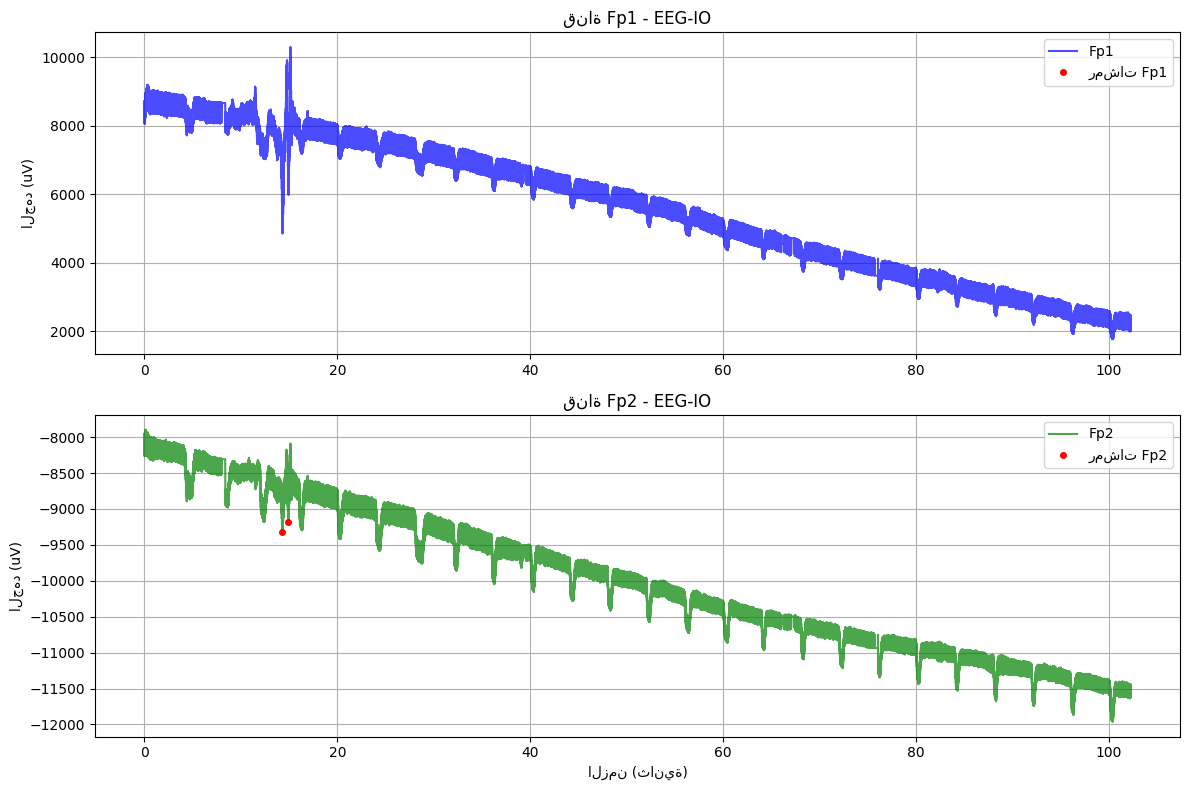


🔍 اختبار على: /content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-IO
📁 معالجة الملف: S00_data.csv
✅ تم تحميل 25568 عينة
🚀 نظام التحكم في الكرسي جاهز - الحالة الابتدائية: 🟢 يتحرك
🔄 بدء الاختبار على 7500 عينة (30.0 ثانية)
⏰ 1.0 ثانية - الرمشات المزدوجة: 0
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.564 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
⏰ 2.0 ثانية - الرمشات المزدوجة: 1
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.300 ثانية
🔄 تغيير حالة الكرسي: 🟢 يتحرك
⏰ 3.0 ثانية - الرمشات المزدوجة: 2
⏰ 4.0 ثانية - الرمشات المزدوجة: 2
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.300 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
⏰ 5.0 ثانية - الرمشات المزدوجة: 3
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.300 ثانية
🔄 تغيير حالة الكرسي: 🟢 يتحرك
⏰ 6.0 ثانية - الرمشات المزدوجة: 4
⏰ 7.0 ثانية - الرمشات المزدوجة: 4
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.384 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
⏰ 8.0 ثانية - الرمشات المزدوجة: 5
⏰ 9.0 ثانية - الرمشات المزدوجة: 5
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.300 ثانية
🔄 تغيير حالة الكرسي: 🟢 يتحرك
⏰ 10.0 ثانية - الرم

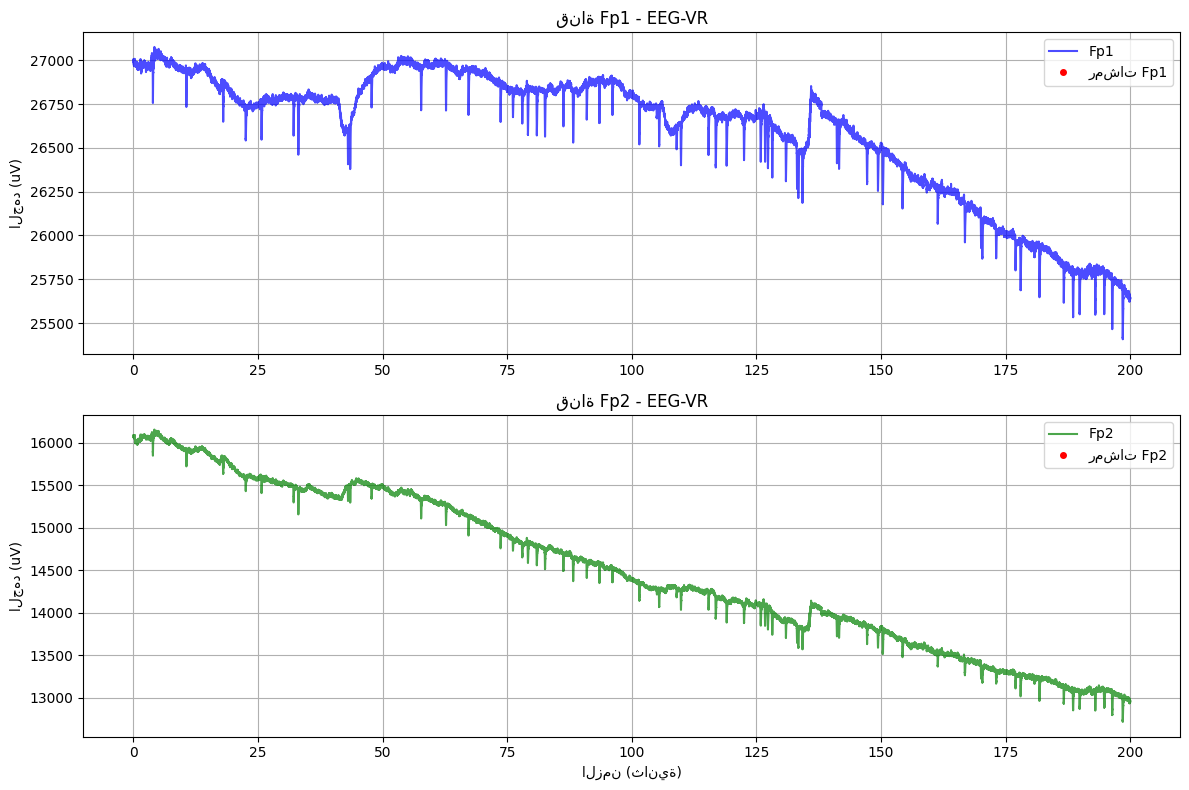


🔍 اختبار على: /content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-VR
📁 معالجة الملف: S00R_data.csv
✅ تم تحميل 50001 عينة
🚀 نظام التحكم في الكرسي جاهز - الحالة الابتدائية: 🟢 يتحرك
🔄 بدء الاختبار على 7500 عينة (30.0 ثانية)
⏰ 1.0 ثانية - الرمشات المزدوجة: 0
⏰ 2.0 ثانية - الرمشات المزدوجة: 0
⏰ 3.0 ثانية - الرمشات المزدوجة: 0
⏰ 4.0 ثانية - الرمشات المزدوجة: 0
⏰ 5.0 ثانية - الرمشات المزدوجة: 0
⏰ 6.0 ثانية - الرمشات المزدوجة: 0
⏰ 7.0 ثانية - الرمشات المزدوجة: 0
⏰ 8.0 ثانية - الرمشات المزدوجة: 0
⏰ 9.0 ثانية - الرمشات المزدوجة: 0
⏰ 10.0 ثانية - الرمشات المزدوجة: 0
⏰ 11.0 ثانية - الرمشات المزدوجة: 0
⏰ 12.0 ثانية - الرمشات المزدوجة: 0
⏰ 13.0 ثانية - الرمشات المزدوجة: 0
⏰ 14.0 ثانية - الرمشات المزدوجة: 0
⏰ 15.0 ثانية - الرمشات المزدوجة: 0
⏰ 16.0 ثانية - الرمشات المزدوجة: 0
⏰ 17.0 ثانية - الرمشات المزدوجة: 0
⏰ 18.0 ثانية - الرمشات المزدوجة: 0
⏰ 19.0 ثانية - الرمشات المزدوجة: 0
⏰ 20.0 ثانية - الرمشات المزدوجة: 0
⏰ 21.0 ثانية - الرمشات المزدوجة: 0
⏰ 22.0 ثانية - الرمشات المزدوج

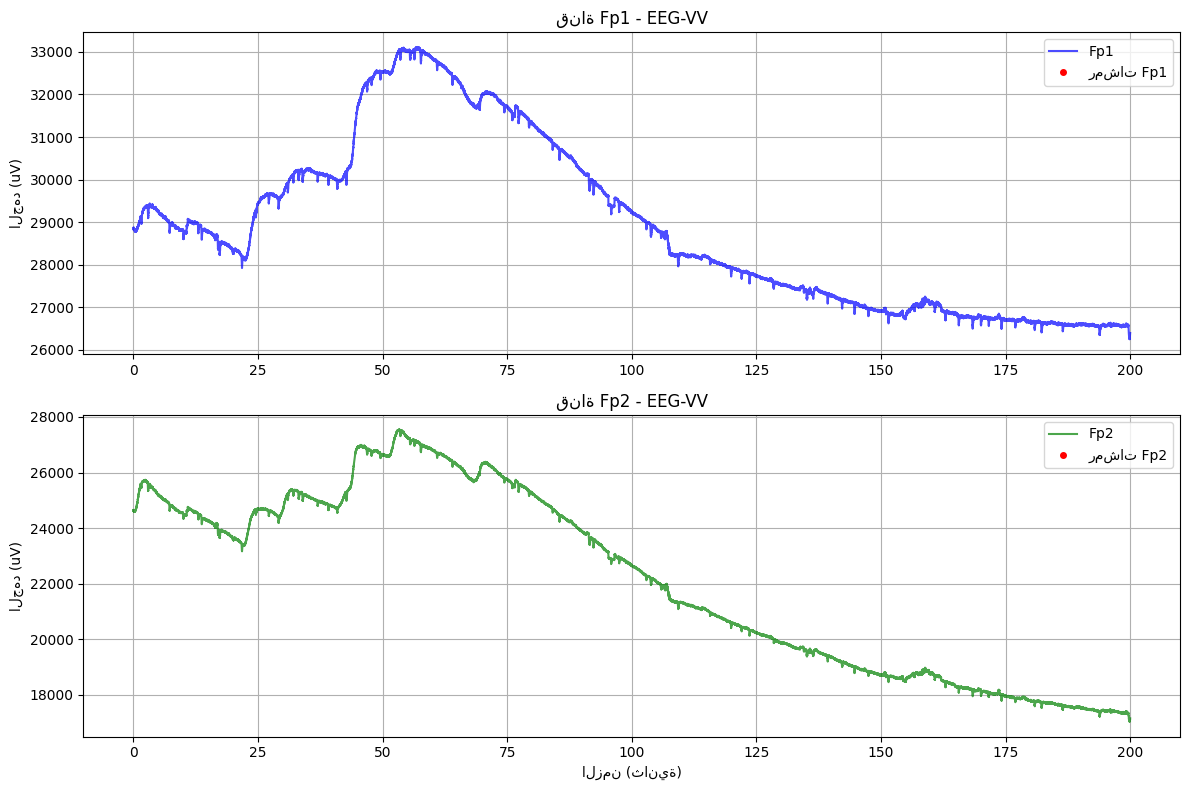


🔍 اختبار على: /content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-VV
📁 معالجة الملف: S00V_data.csv
✅ تم تحميل 50001 عينة
🚀 نظام التحكم في الكرسي جاهز - الحالة الابتدائية: 🟢 يتحرك
🔄 بدء الاختبار على 7500 عينة (30.0 ثانية)
⏰ 1.0 ثانية - الرمشات المزدوجة: 0
⏰ 2.0 ثانية - الرمشات المزدوجة: 0
⏰ 3.0 ثانية - الرمشات المزدوجة: 0
⏰ 4.0 ثانية - الرمشات المزدوجة: 0
⏰ 5.0 ثانية - الرمشات المزدوجة: 0
⏰ 6.0 ثانية - الرمشات المزدوجة: 0
⏰ 7.0 ثانية - الرمشات المزدوجة: 0
⏰ 8.0 ثانية - الرمشات المزدوجة: 0
⏰ 9.0 ثانية - الرمشات المزدوجة: 0
⏰ 10.0 ثانية - الرمشات المزدوجة: 0
⏰ 11.0 ثانية - الرمشات المزدوجة: 0
⏰ 12.0 ثانية - الرمشات المزدوجة: 0
⏰ 13.0 ثانية - الرمشات المزدوجة: 0
⏰ 14.0 ثانية - الرمشات المزدوجة: 0
⏰ 15.0 ثانية - الرمشات المزدوجة: 0
⏰ 16.0 ثانية - الرمشات المزدوجة: 0
⏰ 17.0 ثانية - الرمشات المزدوجة: 0
⏰ 18.0 ثانية - الرمشات المزدوجة: 0
⏰ 19.0 ثانية - الرمشات المزدوجة: 0
⏰ 20.0 ثانية - الرمشات المزدوجة: 0
⏰ 21.0 ثانية - الرمشات المزدوجة: 0
⏰ 22.0 ثانية - الرمشات المزدوج

In [21]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
import time
import matplotlib.pyplot as plt

class RealTimeBlinkController:
    """
    متحكم في الوقت الحقيقي للكرسي بالرمش المزدوج
    """

    def __init__(self, fs=250, double_blink_max_interval=0.8):
        self.fs = fs
        self.double_blink_max_interval = double_blink_max_interval
        self.last_blink_time = None
        self.is_moving = True
        self.data_buffer = []
        self.buffer_duration = 3  # ثواني
        self.double_blink_count = 0

        print("🚀 نظام التحكم في الكرسي جاهز - الحالة الابتدائية: 🟢 يتحرك")

    def process_eeg_sample(self, sample_fp1, sample_fp2, current_time=None):
        """
        معالجة عينة EEG فوراً عند استقبالها
        """
        if current_time is None:
            current_time = time.time()

        # إضافة البيانات للعازلة
        self.data_buffer.append({
            'time': current_time,
            'fp1': sample_fp1,
            'fp2': sample_fp2
        })

        # الحفاظ على حجم العازلة
        while self.data_buffer and current_time - self.data_buffer[0]['time'] > self.buffer_duration:
            self.data_buffer.pop(0)

        # فحص الرمش المزدوج
        if len(self.data_buffer) > self.fs * 1.0:  # عند وجود بيانات كافية
            return self._check_double_blink()

        return False

    def _check_double_blink(self):
        """فحص العازلة للكشف عن الرمش المزدوج"""
        if len(self.data_buffer) < self.fs * 1.5:
            return False

        times = [item['time'] for item in self.data_buffer]
        fp1_data = [item['fp1'] for item in self.data_buffer]
        fp2_data = [item['fp2'] for item in self.data_buffer]

        # اكتشاف الرمشات
        blinks_fp1 = self._detect_blinks_simple(fp1_data, times)
        blinks_fp2 = self._detect_blinks_simple(fp2_data, times)

        # دمج الرمشات
        all_blinks = sorted(blinks_fp1 + blinks_fp2)

        # اكتشاف الرمش المزدوج
        detected = self._find_double_blink(all_blinks)
        if detected:
            self._toggle_wheelchair()

        return detected

    def _detect_blinks_simple(self, data, times):
        """اكتشاف الرمشات بطريقة مبسطة"""
        if len(data) < 10:
            return []

        data_array = np.array(data)

        # البحث عن قمم سالبة (رمش العين)
        peaks, properties = find_peaks(
            -data_array,
            height=np.std(data_array) * 1.5,
            distance=int(0.3 * self.fs),  # 300ms بين الرمشات كحد أدنى
            prominence=np.std(data_array) * 1.0
        )

        blink_times = []
        for peak in peaks:
            if peak < len(times):
                blink_times.append(times[peak])

        return blink_times

    def _find_double_blink(self, blink_times):
        """البحث عن نمط الرمش المزدوج"""
        if len(blink_times) < 2:
            return False

        for i in range(len(blink_times) - 1):
            time_diff = blink_times[i + 1] - blink_times[i]
            if 0.1 <= time_diff <= self.double_blink_max_interval:
                print(f"🎯 تم اكتشاف رمش مزدوج! الفارق: {time_diff:.3f} ثانية")
                self.double_blink_count += 1
                return True

        return False

    def _toggle_wheelchair(self):
        """تبديل حالة الكرسي"""
        self.is_moving = not self.is_moving
        state = "🟢 يتحرك" if self.is_moving else "🔴 متوقف"
        print(f"🔄 تغيير حالة الكرسي: {state}")
        self.data_buffer = []  # إعادة تعيين العازلة بعد الكشف

    def get_status(self):
        return {
            'moving': self.is_moving,
            'double_blinks_detected': self.double_blink_count,
            'buffer_size': len(self.data_buffer)
        }

def load_and_test_dataset(dataset_path, file_index=0, test_duration=60):
    """
    تحميل مجموعة بيانات واختبار النظام عليها
    """
    print(f"\n{'='*60}")
    print(f"🔍 اختبار على: {dataset_path}")
    print(f"{'='*60}")

    # تحديد نوع البيانات
    is_eeg_io = 'EEG-IO' in dataset_path
    is_eeg_vr = 'EEG-VR' in dataset_path
    is_eeg_vv = 'EEG-VV' in dataset_path

    # الحصول على قائمة الملفات
    data_files = [f for f in os.listdir(dataset_path)
                 if os.path.isfile(os.path.join(dataset_path, f)) and '_data' in f]

    if not data_files:
        print(f"❌ لا توجد ملفات بيانات في {dataset_path}")
        return None

    if file_index >= len(data_files):
        file_index = 0

    file_sig = data_files[file_index]
    print(f"📁 معالجة الملف: {file_sig}")

    # تحميل البيانات
    try:
        if is_eeg_io:
            data = np.loadtxt(open(os.path.join(dataset_path, file_sig), "rb"),
                             delimiter=";", skiprows=1, usecols=(0,1,2))
        else:
            data = np.loadtxt(open(os.path.join(dataset_path, file_sig), "rb"),
                             delimiter=",", skiprows=5, usecols=(0,1,2))
            data = data[0:(int(200*250)+1),:]
            data = data[:,0:3]
            data[:,0] = np.array(range(0,len(data)))/250

        print(f"✅ تم تحميل {len(data)} عينة")

        # اختبار النظام
        return test_controller_on_data(data, test_duration)

    except Exception as e:
        print(f"❌ خطأ في تحميل الملف: {e}")
        return None

def test_controller_on_data(data, test_duration=60):
    """
    اختبار المتحكم على بيانات محملة
    """
    controller = RealTimeBlinkController()

    # تحديد مدة الاختبار
    total_samples = min(len(data), int(test_duration * 250))
    data = data[:total_samples]

    print(f"🔄 بدء الاختبار على {total_samples} عينة ({total_samples/250:.1f} ثانية)")

    # محاكاة الوقت الحقيقي
    start_time = time.time()
    detected_count = 0

    for i, sample in enumerate(data):
        # استخراج القناتين Fp1 و Fp2
        fp1 = sample[1] if len(sample) > 1 else sample[0]
        fp2 = sample[2] if len(sample) > 2 else sample[0]

        # وقت محاكاة (بناءً على الفهرس وتردد العينة)
        current_time = start_time + (i / 250.0)

        # معالجة العينة
        detected = controller.process_eeg_sample(fp1, fp2, current_time)
        if detected:
            detected_count += 1

        # عرض التقدم كل ثانية
        if i % 250 == 0 and i > 0:
            elapsed = i / 250.0
            print(f"⏰ {elapsed:.1f} ثانية - الرمشات المزدوجة: {detected_count}")

    # النتائج النهائية
    final_status = controller.get_status()
    print(f"\n📊 النتائج النهائية:")
    print(f"   - الرمشات المزدوجة المكتشفة: {final_status['double_blinks_detected']}")
    print(f"   - حالة الكرسي النهائية: {'🟢 يتحرك' if final_status['moving'] else '🔴 متوقف'}")
    print(f"   - مدة الاختبار: {total_samples/250:.1f} ثانية")

    return final_status

def analyze_dataset_patterns(dataset_path, file_index=0):
    """
    تحليل أنماط الرمشات في البيانات
    """
    print(f"\n📈 تحليل أنماط الرمشات في {dataset_path}")

    # تحميل البيانات
    is_eeg_io = 'EEG-IO' in dataset_path
    data_files = [f for f in os.listdir(dataset_path)
                 if os.path.isfile(os.path.join(dataset_path, f)) and '_data' in f]

    if not data_files:
        return

    file_sig = data_files[file_index]

    try:
        if is_eeg_io:
            data = np.loadtxt(open(os.path.join(dataset_path, file_sig), "rb"),
                             delimiter=";", skiprows=1, usecols=(0,1,2))
        else:
            data = np.loadtxt(open(os.path.join(dataset_path, file_sig), "rb"),
                             delimiter=",", skiprows=5, usecols=(0,1,2))
            data = data[0:(int(200*250)+1),:]
            data = data[:,0:3]
            data[:,0] = np.array(range(0,len(data)))/250

        # تحليل البيانات
        fp1_data = data[:, 1]
        fp2_data = data[:, 2]

        print(f"📊 إحصائيات البيانات:")
        print(f"   - متوسط Fp1: {np.mean(fp1_data):.2f} ± {np.std(fp1_data):.2f}")
        print(f"   - متوسط Fp2: {np.mean(fp2_data):.2f} ± {np.std(fp2_data):.2f}")
        print(f"   - مدى Fp1: [{np.min(fp1_data):.2f}, {np.max(fp1_data):.2f}]")
        print(f"   - مدى Fp2: [{np.min(fp2_data):.2f}, {np.max(fp2_data):.2f}]")

        # اكتشاف الرمشات للتحليل
        controller = RealTimeBlinkController()
        blink_times_fp1 = controller._detect_blinks_simple(fp1_data, range(len(fp1_data)))
        blink_times_fp2 = controller._detect_blinks_simple(fp2_data, range(len(fp2_data)))

        print(f"👁️ إحصائيات الرمشات:")
        print(f"   - عدد الرمشات في Fp1: {len(blink_times_fp1)}")
        print(f"   - عدد الرمشات في Fp2: {len(blink_times_fp2)}")

        # رسم البيانات
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(data[:, 0], fp1_data, 'b-', alpha=0.7, label='Fp1')
        plt.plot([t/250 for t in blink_times_fp1], [fp1_data[t] for t in blink_times_fp1],
                'ro', markersize=4, label='رمشات Fp1')
        plt.title(f'قناة Fp1 - {os.path.basename(dataset_path)}')
        plt.ylabel('الجهد (uV)')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.plot(data[:, 0], fp2_data, 'g-', alpha=0.7, label='Fp2')
        plt.plot([t/250 for t in blink_times_fp2], [fp2_data[t] for t in blink_times_fp2],
                'ro', markersize=4, label='رمشات Fp2')
        plt.title(f'قناة Fp2 - {os.path.basename(dataset_path)}')
        plt.xlabel('الزمن (ثانية)')
        plt.ylabel('الجهد (uV)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ خطأ في التحليل: {e}")

def main():
    """
    الدالة الرئيسية لتجربة النظام على جميع البيانات
    """
    # المسارات المتوقعة للمجلدات
    base_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks"  # افترض أن المجلدات في نفس directory

    datasets_to_test = [
        'EEG-IO',
        'EEG-VR',
        'EEG-VV'
    ]

    results = {}

    print("🎯 بدء تجربة نظام التحكم في الكرسي بالرمش المزدوج")
    print("=" * 60)

    # اختبار على كل مجموعة بيانات
    for dataset_name in datasets_to_test:
        dataset_path = os.path.join(base_path, dataset_name)

        if os.path.exists(dataset_path):
            # أولاً: تحليل الأنماط
            analyze_dataset_patterns(dataset_path)

            # ثانياً: اختبار النظام
            result = load_and_test_dataset(dataset_path, test_duration=30)
            if result:
                results[dataset_name] = result
        else:
            print(f"⚠️ المجلد {dataset_path} غير موجود")

    # عرض ملخص النتائج
    print(f"\n{'='*60}")
    print("📋 ملخص النتائج النهائية")
    print(f"{'='*60}")

    for dataset, result in results.items():
        status = "🟢 يتحرك" if result['moving'] else "🔴 متوقف"
        print(f"{dataset}: {result['double_blinks_detected']} رمش مزدوج - الحالة: {status}")

# إذا أردت اختبار ملف محدد
def test_specific_file(dataset_path, filename, test_duration=30):
    """
    اختبار ملف محدد
    """
    print(f"🎯 اختبار ملف محدد: {filename}")

    try:
        if 'EEG-IO' in dataset_path:
            data = np.loadtxt(open(os.path.join(dataset_path, filename), "rb"),
                             delimiter=";", skiprows=1, usecols=(0,1,2))
        else:
            data = np.loadtxt(open(os.path.join(dataset_path, filename), "rb"),
                             delimiter=",", skiprows=5, usecols=(0,1,2))
            data = data[0:(int(200*250)+1),:]
            data = data[:,0:3]
            data[:,0] = np.array(range(0,len(data)))/250

        return test_controller_on_data(data, test_duration)

    except Exception as e:
        print(f"❌ خطأ في تحميل الملف: {e}")
        return None

if __name__ == "__main__":
    # الاختبار الشامل
    main()

    # لاختبار ملف محدد:
    # test_specific_file('EEG-IO', 'S1_data.csv', test_duration=30)

In [17]:
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import time
from collections import deque
import threading

class RealTimeWheelchairController:
    """
    نظام تحكم في الكرسي المتحرك بالرمش المزدوج - معدل للريل تايم
    """

    def __init__(self, fs=250, double_blink_threshold=0.6):
        self.fs = fs
        self.double_blink_threshold = double_blink_threshold

        # حالة النظام
        self.is_moving = True
        self.last_blink_time = None
        self.double_blink_count = 0

        # عازلة البيانات (آخر 3 ثواني)
        self.buffer_duration = 3
        self.buffer_size = int(self.buffer_duration * fs)
        self.data_buffer = deque(maxlen=self.buffer_size)
        self.time_buffer = deque(maxlen=self.buffer_size)

        # معاملات الكشف
        self.blink_height_threshold = 3.0  # تعدل حسب بياناتك
        self.blink_distance = int(0.2 * fs)  # 200ms بين الرمشات

        # للتحكم في التوقيت
        self.last_process_time = 0
        self.process_interval = 0.1  # معالجة كل 100ms

        print("🔄 نظام الكرسي المتحرك جاهز - الحالة: 🟢 يتحرك")

    def add_eeg_data(self, fp1, fp2, timestamp=None):
        """
        إضافة بيانات EEG جديدة - تستدعى عند كل عينة
        """
        if timestamp is None:
            timestamp = time.time()

        # تخزين البيانات في العازلة
        self.data_buffer.append((fp1, fp2))
        self.time_buffer.append(timestamp)

        # معالجة البيانات بتردد ثابت (ليس عند كل عينة)
        current_time = time.time()
        if current_time - self.last_process_time >= self.process_interval:
            self.last_process_time = current_time
            self._process_buffer()

    def _process_buffer(self):
        """معالجة البيانات في العازلة"""
        if len(self.data_buffer) < int(1.5 * self.fs):  # تحتاج 1.5 ثانية على الأقل
            return

        # تحويل العازلة إلى مصفوفات
        data_array = np.array(self.data_buffer)
        time_array = np.array(self.time_buffer)

        # اكتشاف الرمشات
        blink_times = self._detect_blinks_in_buffer(data_array, time_array)

        # البحث عن الرمش المزدوج
        self._check_double_blink(blink_times)

    def _detect_blinks_in_buffer(self, data_array, time_array):
        """اكتشاف الرمشات في العازلة الحالية"""
        blink_times = []

        # معالجة كل قناة
        for channel_idx in [0, 1]:  # Fp1, Fp2
            channel_data = data_array[:, channel_idx]

            # تطبيق مرشح بسيط (متوسط متحرك)
            filtered_data = self._moving_average(channel_data, window=5)

            # البحث عن القمم السالبة (رمش العين)
            peaks, properties = find_peaks(
                -filtered_data,  # نبحث عن القمم السالبة
                height=np.std(filtered_data) * self.blink_height_threshold,
                distance=self.blink_distance,
                prominence=np.std(filtered_data) * 1.5
            )

            # إضافة الأوقات
            for peak in peaks:
                if peak < len(time_array):
                    blink_times.append(time_array[peak])

        return sorted(list(set(blink_times)))  # إزالة التكرارات

    def _moving_average(self, data, window=5):
        """مرشح متوسط متحرك بسيط"""
        if len(data) < window:
            return data

        return np.convolve(data, np.ones(window)/window, mode='same')

    def _check_double_blink(self, blink_times):
        """الكشف عن الرمش المزدوج"""
        if len(blink_times) < 2:
            return False

        # البحث عن رمشتين متتاليتين
        for i in range(len(blink_times) - 1):
            time_diff = blink_times[i + 1] - blink_times[i]

            if 0.1 <= time_diff <= self.double_blink_threshold:
                print(f"🎯 تم اكتشاف رمش مزدوج! الفارق: {time_diff:.3f} ثانية")
                self.double_blink_count += 1
                self._toggle_wheelchair()
                self._clear_buffer()  # مسح العازلة بعد الكشف
                return True

        return False

    def _toggle_wheelchair(self):
        """تبديل حالة الكرسي"""
        self.is_moving = not self.is_moving
        state = "🟢 يتحرك" if self.is_moving else "🔴 متوقف"
        print(f"🔄 تغيير حالة الكرسي: {state}")

    def _clear_buffer(self):
        """مسح العازلة بعد اكتشاف الرمش المزدوج"""
        self.data_buffer.clear()
        self.time_buffer.clear()

    def get_status(self):
        """الحصول على حالة النظام"""
        return {
            'moving': self.is_moving,
            'double_blinks_detected': self.double_blink_count,
            'buffer_samples': len(self.data_buffer)
        }

# -------------------------------------------------------------------
# استخدام مع جهاز EEG حقيقي
# -------------------------------------------------------------------

def connect_to_eeg_device(controller):
    """
    دالة للاتصال بجهاز EEG حقيقي (تعدل حسب جهازك)
    """
    try:
        # مثال لـ OpenBCI مع brainflow
        from brainflow.board_shim import BoardShim, BoardIds
        from brainflow.data_filter import DataFilter

        board_id = BoardIds.SYNTHETIC_BOARD  # تغير لجهازك الحقيقي
        board = BoardShim(board_id, None)
        board.prepare_session()
        board.start_stream()

        print("📡 متصل بجهاز EEG...")

        while True:
            # قراءة البيانات من الجهاز
            data = board.get_board_data()
            if data.shape[1] > 0:
                # استخراج قناتي Fp1 و Fp2 (تعدل حسب تكوين جهازك)
                fp1_data = data[0]  # القناة الأولى
                fp2_data = data[1]  # القناة الثانية

                # معالجة كل عينة
                for i in range(len(fp1_data)):
                    controller.add_eeg_data(fp1_data[i], fp2_data[i])

            time.sleep(0.01)  # عدم إشغال المعالج

    except KeyboardInterrupt:
        print("🛑 إيقاف النظام")
    except Exception as e:
        print(f"❌ خطأ في الاتصال: {e}")
    finally:
        try:
            board.stop_stream()
            board.release_session()
        except:
            pass

# -------------------------------------------------------------------
# بديل: محاكاة للاختبار
# -------------------------------------------------------------------

def simulate_real_time_test():
    """محاكاة نظام الريل تايم للاختبار"""
    controller = RealTimeWheelchairController()

    print("🧪 بدء محاكاة النظام في الوقت الحقيقي...")
    print("=" * 50)

    start_time = time.time()

    # محاكاة 30 ثانية من البيانات
    for i in range(int(30 * controller.fs)):
        current_time = start_time + (i / controller.fs)

        # محاكاة بيانات EEG
        if 5.0 <= current_time - start_time <= 5.2 or 5.3 <= current_time - start_time <= 5.5:
            # فترة رمش مزدوج
            fp1 = np.random.normal(-40, 8)  # إشارة سالبة قوية
            fp2 = np.random.normal(-35, 8)
        elif 15.0 <= current_time - start_time <= 15.2 or 15.25 <= current_time - start_time <= 15.45:
            # فترة رمش مزدوج أخرى
            fp1 = np.random.normal(-45, 7)
            fp2 = np.random.normal(-40, 7)
        else:
            # بيانات عادية
            fp1 = np.random.normal(0, 15)
            fp2 = np.random.normal(0, 15)

        # إضافة البيانات للنظام
        controller.add_eeg_data(fp1, fp2, current_time)

        # عرض الحالة كل ثانية
        if i % controller.fs == 0 and i > 0:
            elapsed = i / controller.fs
            status = controller.get_status()
            print(f"⏰ {elapsed:.1f}s - حالات: {status['double_blinks_detected']} - العازلة: {status['buffer_samples']}")

        time.sleep(1/controller.fs)  # محاكاة تردد العينة

    print("=" * 50)
    print("✅ انتهت المحاكاة")
    print(f"النتيجة النهائية: {controller.get_status()}")

if __name__ == "__main__":
    # اختبار بالمحاكاة
    simulate_real_time_test()

    # لاستخدامه مع جهاز حقيقي:
    # controller = RealTimeWheelchairController()
    # connect_to_eeg_device(controller)

🔄 نظام الكرسي المتحرك جاهز - الحالة: 🟢 يتحرك
🧪 بدء محاكاة النظام في الوقت الحقيقي...
⏰ 1.0s - حالات: 0 - العازلة: 251
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.264 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
⏰ 2.0s - حالات: 1 - العازلة: 47
⏰ 3.0s - حالات: 1 - العازلة: 297
⏰ 4.0s - حالات: 1 - العازلة: 547
⏰ 5.0s - حالات: 1 - العازلة: 750
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.192 ثانية
🔄 تغيير حالة الكرسي: 🟢 يتحرك
⏰ 6.0s - حالات: 2 - العازلة: 162
⏰ 7.0s - حالات: 2 - العازلة: 412
⏰ 8.0s - حالات: 2 - العازلة: 662
⏰ 9.0s - حالات: 2 - العازلة: 750
⏰ 10.0s - حالات: 2 - العازلة: 750
⏰ 11.0s - حالات: 2 - العازلة: 750
⏰ 12.0s - حالات: 2 - العازلة: 750
⏰ 13.0s - حالات: 2 - العازلة: 750
⏰ 14.0s - حالات: 2 - العازلة: 750
⏰ 15.0s - حالات: 2 - العازلة: 750
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.284 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
⏰ 16.0s - حالات: 3 - العازلة: 133
⏰ 17.0s - حالات: 3 - العازلة: 383
⏰ 18.0s - حالات: 3 - العازلة: 633
⏰ 19.0s - حالات: 3 - العازلة: 750
⏰ 20.0s - حالات: 3 - العازلة: 750
⏰ 21.0s - حالات: 3 - العازلة:

In [20]:
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

class BlinkAccuracyTester:
    """
    اختبار دقة كشف الرمش المزدوج على البيانات المخزنة
    """

    def __init__(self, double_blink_threshold=0.6):
        self.double_blink_threshold = double_blink_threshold
        self.results = {}

    def load_dataset_file(self, data_path, labels_path):
        """تحميل ملف بيانات وملف التصنيفات"""
        # تحديد نوع البيانات من المسار
        is_eeg_io = 'EEG-IO' in data_path

        # تحميل البيانات
        if is_eeg_io:
            data = np.loadtxt(data_path, delimiter=";", skiprows=1, usecols=(0,1,2))
        else:
            data = np.loadtxt(data_path, delimiter=",", skiprows=5, usecols=(0,1,2))
            data = data[0:(int(200*250)+1),:]
            data = data[:,0:3]
            data[:,0] = np.array(range(0,len(data)))/250

        # تحميل التصنيفات
        ground_truth_blinks = self.load_labels(labels_path)

        return data, ground_truth_blinks

    def load_labels(self, labels_path):
        """تحميل ملف التصنيفات"""
        blink_times = []

        with open(labels_path, 'r') as f:
            lines = f.readlines()
            reading_blinks = False

            for line in lines:
                line = line.strip()
                if line == "blinks":
                    reading_blinks = True
                    continue

                if reading_blinks and line:
                    parts = line.split(',')
                    if len(parts) == 2:
                        blink_time = float(parts[0])
                        blink_type = int(parts[1])
                        if blink_type < 2:  # الرمشات العادية فقط
                            blink_times.append(blink_time)

        return blink_times

    def detect_double_blinks_offline(self, data, ground_truth):
        """
        كشف الرمش المزدوج على البيانات المسجلة
        """
        # محاكاة النظام الريل تايم على البيانات المسجلة
        controller = RealTimeWheelchairController(double_blink_threshold=self.double_blink_threshold)

        detected_double_blinks = []
        timestamps = data[:, 0]

        # معالجة كل عينة كما في النظام الريل تايم
        for i, sample in enumerate(data):
            fp1 = sample[1]
            fp2 = sample[2]
            current_time = timestamps[i]

            controller.add_eeg_data(fp1, fp2, current_time)

            # تسجيل حالات الرمش المزدوج
            status = controller.get_status()
            if status['double_blinks_detected'] > len(detected_double_blinks):
                detected_double_blinks.append(current_time)

        return detected_double_blinks

    def find_ground_truth_double_blinks(self, ground_truth_times):
        """إيجاد الرمش المزدوج الحقيقي من التصنيفات"""
        double_blinks_truth = []

        ground_truth_sorted = sorted(ground_truth_times)

        i = 0
        while i < len(ground_truth_sorted) - 1:
            time_diff = ground_truth_sorted[i+1] - ground_truth_sorted[i]

            if time_diff <= self.double_blink_threshold:
                double_blinks_truth.append(ground_truth_sorted[i])  # وقت الرمشة الأولى
                i += 2  # تخطي الرمشتين
            else:
                i += 1

        return double_blinks_truth

    def evaluate_file(self, data_path, labels_path, tolerance=1.0):
        """تقييم دقة الكشف على ملف واحد"""
        print(f"🔍 تقييم الملف: {os.path.basename(data_path)}")

        # تحميل البيانات
        data, ground_truth_single = self.load_dataset_file(data_path, labels_path)

        # الكشف عن الرمش المزدوج
        detected_double = self.detect_double_blinks_offline(data, ground_truth_single)

        # إيجاد الرمش المزدوج الحقيقي
        ground_truth_double = self.find_ground_truth_double_blinks(ground_truth_single)

        print(f"   - الرمش المزدوج الحقيقي: {len(ground_truth_double)}")
        print(f"   - الرمش المزدوج المكتشف: {len(detected_double)}")

        # حساب الدقة
        true_positives = 0
        false_positives = 0
        false_negatives = 0

        # مقارنة المكتشف مع الحقيقي
        for detected_time in detected_double:
            matched = False
            for truth_time in ground_truth_double:
                if abs(detected_time - truth_time) <= tolerance:
                    true_positives += 1
                    matched = True
                    break

            if not matched:
                false_positives += 1

        false_negatives = len(ground_truth_double) - true_positives

        # حساب المقاييس
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        accuracy_metrics = {
            'true_positives': true_positives,
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'detected_times': detected_double,
            'ground_truth_times': ground_truth_double
        }

        print(f"   - Precision: {precision:.3f}")
        print(f"   - Recall: {recall:.3f}")
        print(f"   - F1-Score: {f1:.3f}")
        print()

        return accuracy_metrics

    def test_all_datasets(self, base_path="."):
        """اختبار جميع مجموعات البيانات"""
        datasets = ['EEG-IO', 'EEG-VR', 'EEG-VV']
        all_results = {}

        for dataset in datasets:
            dataset_path = os.path.join(base_path, dataset)
            if not os.path.exists(dataset_path):
                print(f"⚠️ المجلد {dataset_path} غير موجود")
                continue

            print(f"\n{'='*60}")
            print(f"📊 اختبار مجموعة: {dataset}")
            print(f"{'='*60}")

            dataset_results = self.test_dataset(dataset_path)
            all_results[dataset] = dataset_results

        # عرض النتائج النهائية
        self.print_final_results(all_results)

        return all_results

    def test_dataset(self, dataset_path, max_files=3):
        """اختبار مجموعة بيانات محددة"""
        data_files = [f for f in os.listdir(dataset_path)
                     if os.path.isfile(os.path.join(dataset_path, f)) and '_data' in f]

        dataset_results = []

        for i, data_file in enumerate(data_files[:max_files]):
            labels_file = data_file.replace('_data', '_labels')
            data_path = os.path.join(dataset_path, data_file)
            labels_path = os.path.join(dataset_path, labels_file)

            if os.path.exists(labels_path):
                result = self.evaluate_file(data_path, labels_path)
                result['file'] = data_file
                dataset_results.append(result)

        # حساب متوسط الدقة للمجموعة
        if dataset_results:
            avg_precision = np.mean([r['precision'] for r in dataset_results])
            avg_recall = np.mean([r['recall'] for r in dataset_results])
            avg_f1 = np.mean([r['f1_score'] for r in dataset_results])

            print(f"📈 متوسط دقة {os.path.basename(dataset_path)}:")
            print(f"   - Precision: {avg_precision:.3f}")
            print(f"   - Recall: {avg_recall:.3f}")
            print(f"   - F1-Score: {avg_f1:.3f}")

        return dataset_results

    def print_final_results(self, all_results):
        """عرض النتائج النهائية"""
        print(f"\n{'='*80}")
        print("🎯 النتائج النهائية لجميع مجموعات البيانات")
        print(f"{'='*80}")

        for dataset, results in all_results.items():
            if results:
                precisions = [r['precision'] for r in results]
                recalls = [r['recall'] for r in results]
                f1_scores = [r['f1_score'] for r in results]

                print(f"\n{dataset}:")
                print(f"   Precision: {np.mean(precisions):.3f} ± {np.std(precisions):.3f}")
                print(f"   Recall:    {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
                print(f"   F1-Score:  {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

        print(f"\n{'='*80}")

# -------------------------------------------------------------------
# التشغيل والاختبار
# -------------------------------------------------------------------

def main():
    """الدالة الرئيسية للتشغيل"""

    # اختبار ١: اختبار الدقة على البيانات المخزنة
    print("🧪 بدء اختبار الدقة على البيانات المخزنة...")
    tester = BlinkAccuracyTester(double_blink_threshold=0.6)
    results = tester.test_all_datasets()

    # اختبار ٢: محاكاة النظام الريل تايم
    print("\n" + "="*80)
    print("🔄 بدء محاكاة النظام في الوقت الحقيقي...")
    print("="*80)

    simulate_real_time_test()

if __name__ == "__main__":
    main()

🧪 بدء اختبار الدقة على البيانات المخزنة...
⚠️ المجلد ./EEG-IO غير موجود
⚠️ المجلد ./EEG-VR غير موجود
⚠️ المجلد ./EEG-VV غير موجود

🎯 النتائج النهائية لجميع مجموعات البيانات


🔄 بدء محاكاة النظام في الوقت الحقيقي...
🔄 نظام الكرسي المتحرك جاهز - الحالة: 🟢 يتحرك
🧪 بدء محاكاة النظام في الوقت الحقيقي...
⏰ 1.0s - حالات: 0 - العازلة: 251
⏰ 2.0s - حالات: 0 - العازلة: 501
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.236 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
⏰ 3.0s - حالات: 1 - العازلة: 222
⏰ 4.0s - حالات: 1 - العازلة: 472
⏰ 5.0s - حالات: 1 - العازلة: 722
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.112 ثانية
🔄 تغيير حالة الكرسي: 🟢 يتحرك
⏰ 6.0s - حالات: 2 - العازلة: 204
⏰ 7.0s - حالات: 2 - العازلة: 454
⏰ 8.0s - حالات: 2 - العازلة: 704
⏰ 9.0s - حالات: 2 - العازلة: 750
⏰ 10.0s - حالات: 2 - العازلة: 750
🎯 تم اكتشاف رمش مزدوج! الفارق: 0.344 ثانية
🔄 تغيير حالة الكرسي: 🔴 متوقف
⏰ 11.0s - حالات: 3 - العازلة: 135
⏰ 12.0s - حالات: 3 - العازلة: 385
⏰ 13.0s - حالات: 3 - العازلة: 635
⏰ 14.0s - حالات: 3 - العازلة: 750
⏰ 15.0s - حالات: 